<a href="https://colab.research.google.com/github/ylkim1947/Section4_Project/blob/main/Outlier_Detection_car_damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/project4/yolov5/


/content/drive/MyDrive/Colab Notebooks/project4/yolov5


In [ ]:
#import os
#os.environ['KAGGLE_USERNAME'] = 'kairess' # username
#os.environ['KAGGLE_KEY'] = '' # key

In [ ]:
#!kaggle datasets download -d arunrk7/surface-crack-detection

In [ ]:
#!unzip -q surface-crack-detection.zip

# Install alibi_detect

In [ ]:
!pip install alibi-detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 98.5 MB/s 
     |████████████████████████████████| 4.9 MB 69.2 MB/s 
     |████████████████████████████████| 34.5 MB 6.6 MB/s 
     |████████████████████████████████| 163 kB 60.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.2
    Uninstalling numba-0.56.2:
      Successfully uninstalled numba-0.56.2


# Import Packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images

- 01-whole: normal images
- 00-damage: crack images

In [ ]:
#img_list = glob('/content/drive/MyDrive/Colab Notebooks/project4/car-damage-dataset/data1a/training/01-whole/*.jpg')
img_list = glob('/content/drive/MyDrive/Colab Notebooks/project4/yolov5/Socar_Hackerthon-2/train/images/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2022)

def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64*2, 64*2))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list[:1000])
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list[:32])
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(1000, 128, 128, 3)
(32, 128, 128, 3)


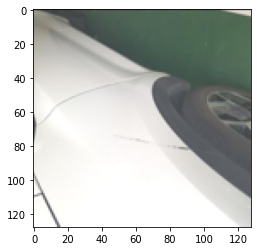

In [ ]:
plt.imshow(x_train[0])

# Build Model

In [ ]:
## modified version

latent_dim = 1024*2

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64*2, 64*2, 3)),
    Conv2D(64*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(1024*2, 4, strides=2, padding='same', activation=tf.nn.relu),

])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128 *4),
    Reshape(target_shape=(4, 4, 128*4)),
    Conv2DTranspose(512*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(256*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32*2, 4, strides=2, padding='same', activation=tf.nn.relu),
   # Conv2DTranspose(3*2, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.05,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [ ]:
encoder_net.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       6272      
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 256)       524544    
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 1024)      4195328   
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 2048)        33556480  
                                                                 
Total params: 38,282,624
Trainable params: 38,282,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_net.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              16785408  
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 1024)       8389632   
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 512)      8389120   
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 32, 32, 128)      1048704   
 Transpose)                                                      
                                                      

In [ ]:
tf.keras.utils.plot_model(od, show_shapes=True)


AttributeError: ignored

# Train

In [ ]:
od.fit(
    x_train,
    epochs=200,
    verbose=True
)

16/16 [=] - 6s 384ms/step - loss_ma: -93165.1934


# Reconstruct Training Image

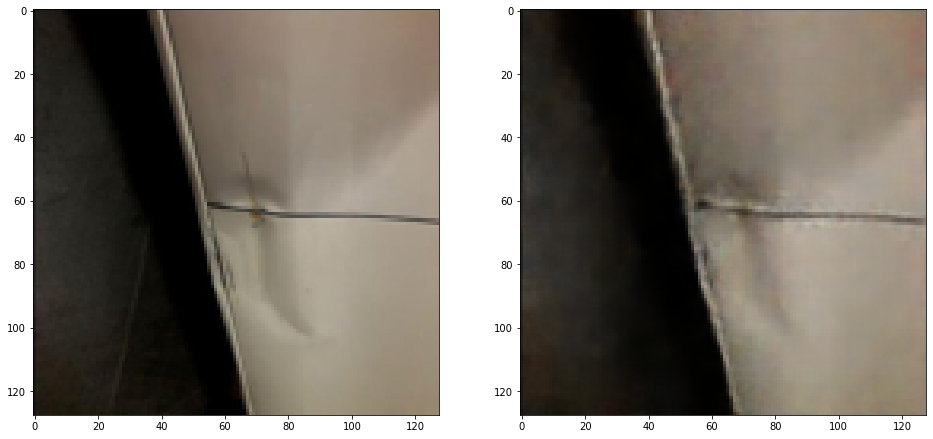

In [ ]:
idx = 32
x = x_train[idx].reshape(1, 128, 128, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

# Validation

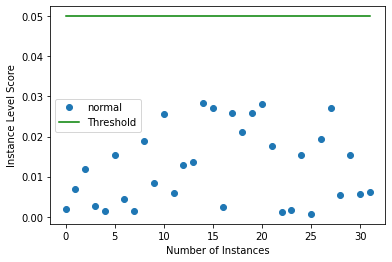

In [ ]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruct Validation Images

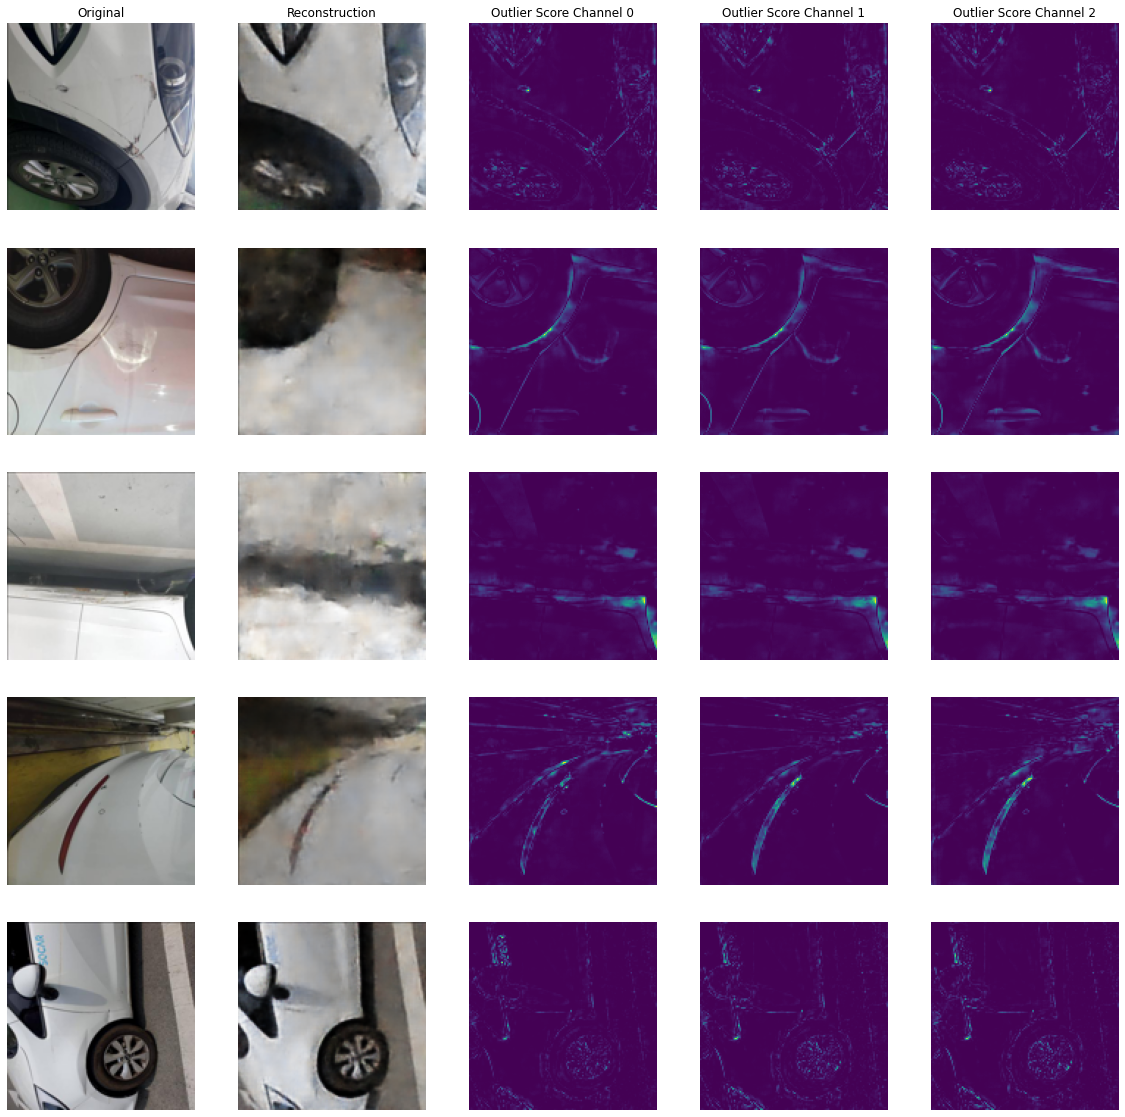

In [ ]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

# Outliers

In [ ]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

<Figure size 1440x1440 with 0 Axes>

In [ ]:
x_recon

array([[[[0.449814  , 0.43757698, 0.42475677],
         [0.63869953, 0.6279055 , 0.6185925 ],
         [0.68822014, 0.68421566, 0.6811859 ],
         ...,
         [0.58773047, 0.56961095, 0.55911607],
         [0.5981049 , 0.5899673 , 0.5719307 ],
         [0.5618622 , 0.55921435, 0.5458955 ]],

        [[0.4516319 , 0.4411962 , 0.4332531 ],
         [0.65447265, 0.6683979 , 0.64469504],
         [0.6847982 , 0.69975525, 0.66274244],
         ...,
         [0.5940533 , 0.5779366 , 0.5556143 ],
         [0.6456849 , 0.62965584, 0.6048866 ],
         [0.61422634, 0.5996944 , 0.5852556 ]],

        [[0.43229568, 0.42217836, 0.3981869 ],
         [0.59696364, 0.6265416 , 0.60633147],
         [0.65471727, 0.6386975 , 0.6156668 ],
         ...,
         [0.5778671 , 0.54899585, 0.5256774 ],
         [0.65292853, 0.62167394, 0.596475  ],
         [0.623025  , 0.6062892 , 0.5913788 ]],

        ...,

        [[0.19477905, 0.16857593, 0.17011942],
         [0.21149233, 0.19778505, 0.18200871]

# Test with Crack Images

In [ ]:
test_img_list = glob('/content/drive/MyDrive/Colab Notebooks/project4/car-damage-dataset/data1a/training/00-damage/*.jpeg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 128, 128, 3)


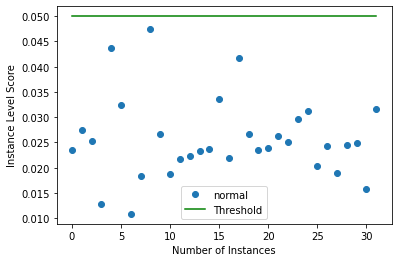

In [ ]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

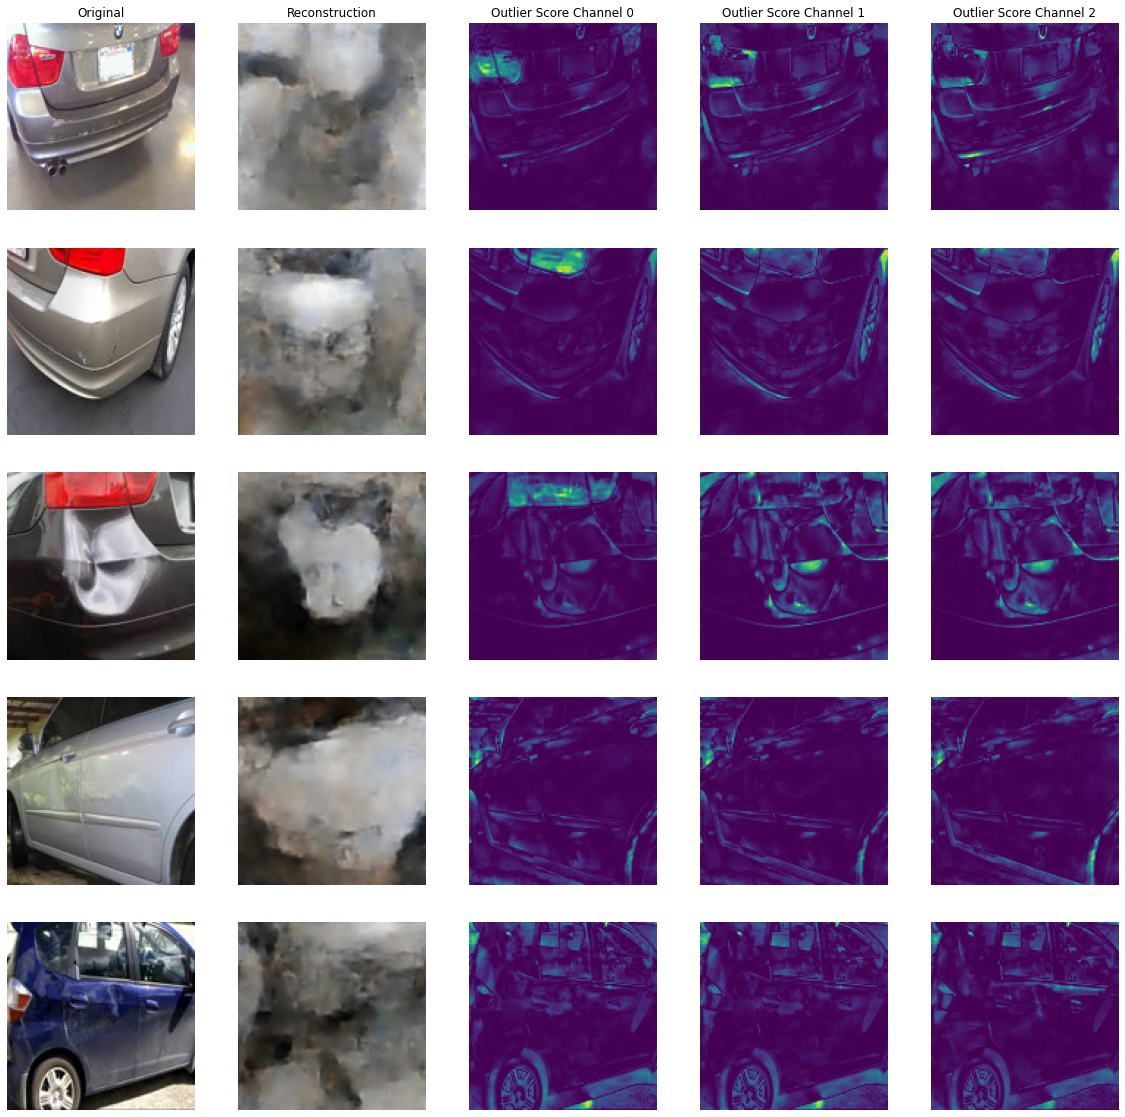

In [ ]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)